In [285]:
from sys import version
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
from os.path import basename, dirname
print(version)

3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [286]:
perfs = glob("nn_*/perf.txt") + glob("xgb_*/perf.txt")
all_perf = list()
for perf in perfs:
    group = dirname(perf)
    print(group)
    perf_data = pd.read_csv(perf, skiprows=2, nrows=14)
    condition = list()
    mae = list()
    mape = list()
    for i, line in perf_data.iterrows():
        splits = str(line.values[0]).rsplit(' ', 4)
        condition.append(splits[0].split(" ",1)[1].strip())
        mae.append(float(splits[2]))
        mape.append(float(splits[4]))

    all_perf.append(pd.DataFrame({
        'condition': condition,
        'mae': mae,
        'mape': mape,
        'folder': [group]*len(mape)
    }))
all_perf = pd.concat(all_perf)
all_perf['agg_level'] = all_perf['folder'].apply(lambda x: '15m' if '15m' in x else '30m')
all_perf['model'] = all_perf['folder'].apply(lambda x: x.split('_')[0] + '/'+ x.split('_')[2])
all_perf = all_perf.pivot_table(index=['condition', 'agg_level'], columns='model', values='mae')
all_perf = all_perf.reset_index('agg_level').sort_values(['agg_level', 'condition'])

nn_15min_summer
nn_15min_winter
nn_30min_combined
nn_15min_combined
nn_30min_summer
nn_30min_winter
xgb_30min_winter
xgb_30min_summer
xgb_30min_combined
xgb_15min_combined
xgb_15min_summer


In [288]:

all_perf.head()

model,agg_level,nn/combined,nn/summer,nn/winter,xgb/combined,xgb/summer,xgb/winter
condition,,,,,,,
EW route,15m,7.061428,8.303957,7.387408,9.589530,10.012008,NaN
Early Morning,15m,5.011329,5.820263,5.475470,7.539040,8.402142,NaN
Evening Peak,15m,8.248627,9.610420,7.965389,10.202344,11.027818,NaN
Midday,15m,6.500403,7.322627,6.288385,7.894685,8.443080,NaN
Morning Peak,15m,6.593124,7.766696,6.456719,8.689217,9.362403,NaN


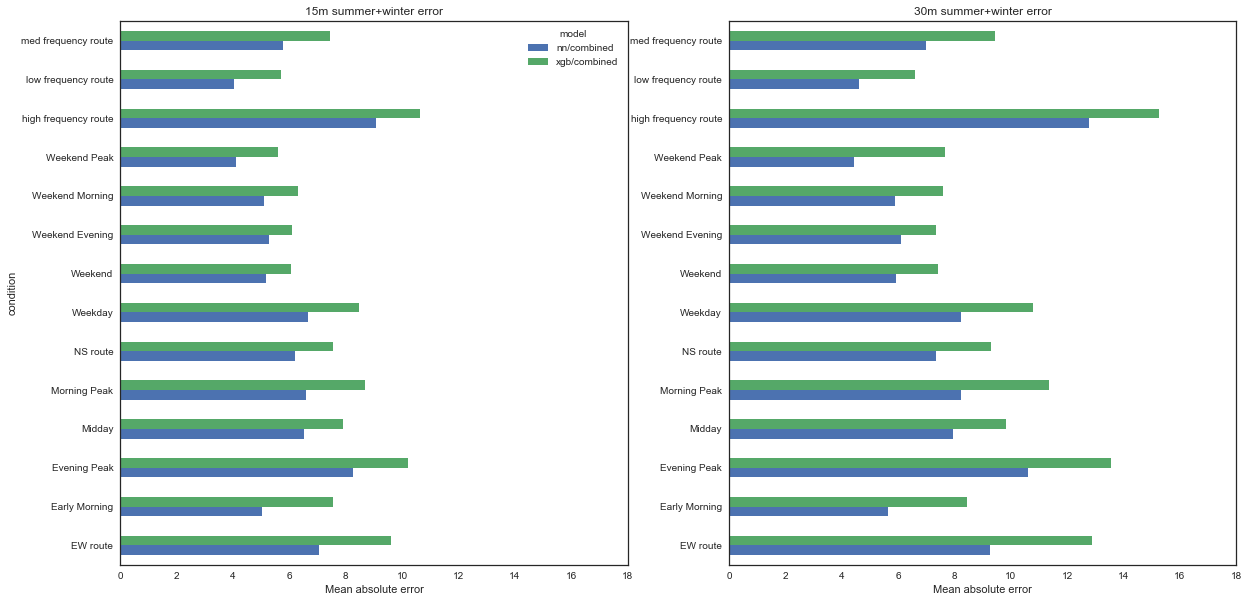

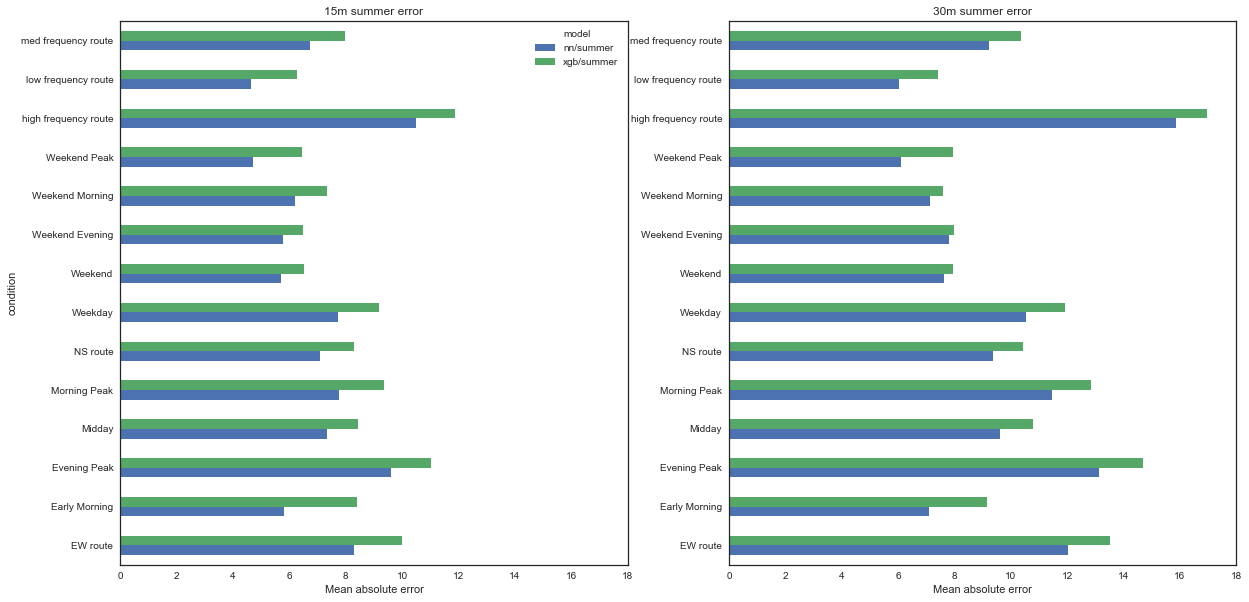

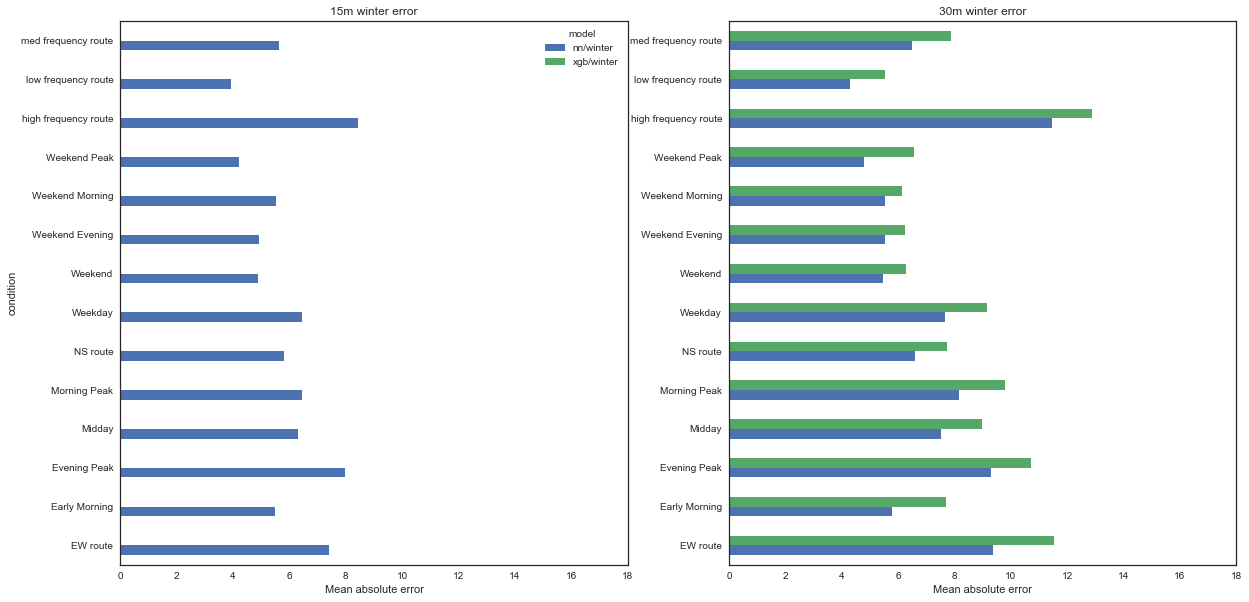

In [290]:
plt.style.use('seaborn-white')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

shared_xlim=(0,18)

cols = [c for c in list(all_perf.columns) if 'combined' in c]
all_perf.loc[all_perf['agg_level'] == '15m', cols].plot.barh(rot=0, ax=axes[0], title="15m summer+winter error", align='center', xlim=shared_xlim)
all_perf.loc[all_perf['agg_level'] == '30m', cols].plot.barh(rot=0, ax=axes[1], title="30m summer+winter error", legend=False, align='center', xlim=shared_xlim)
axes[0].set_xlabel("Mean absolute error")
axes[1].set_xlabel("Mean absolute error")
axes[1].set_ylabel('')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
cols = [c for c in list(all_perf.columns) if 'summer' in c]
all_perf.loc[all_perf['agg_level'] == '15m', cols].plot.barh(rot=0, ax=axes[0], title="15m summer error", align='center', xlim=shared_xlim)
all_perf.loc[all_perf['agg_level'] == '30m', cols].plot.barh(rot=0, ax=axes[1], title="30m summer error", legend=False, align='center', xlim=shared_xlim)
axes[0].set_xlabel("Mean absolute error")
axes[1].set_xlabel("Mean absolute error")
axes[1].set_ylabel('')
plt.show()


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
cols = [c for c in list(all_perf.columns) if 'winter' in c]
all_perf.loc[all_perf['agg_level'] == '15m', cols].plot.barh(rot=0, ax=axes[0], title="15m winter error", align='center', xlim=shared_xlim)
all_perf.loc[all_perf['agg_level'] == '30m', cols].plot.barh(rot=0, ax=axes[1], title="30m winter error", legend=False, align='center', xlim=shared_xlim)
axes[0].set_xlabel("Mean absolute error")
axes[1].set_xlabel("Mean absolute error")
axes[1].set_ylabel('')
plt.show()